In [1]:
import sys
import os
import numpy as np
import multiprocessing
import dill
import matplotlib.pyplot as plt
import pandas as pd

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/../src/simulations_v2")
    sys.path.append(module_path + "/..")
from load_params import load_params

from multi_group_simulation import MultiGroupSimulation

In [2]:
from util_functions import *
from uncertainty_analysis import *
from sim_helper_functions import *
from plot_utils import *
configure_plot(plt)

In [3]:
lhs_output_sim_files = []
for i in range(2000):
    fname = '/home/aaj54/group-testing/notebooks/apr_29_scenarios/point_{}.dill'.format(i)
    lhs_output_sim_files.append(fname)

In [4]:
scenario_data = load_sim_output(lhs_output_sim_files)
res_results = residential_regression(scenario_data)
res_pessimistic = calculate_pessimistic_scenario(res_results)

In [5]:
res_pessimistic

{'daily_self_report_prob': 0.34385098578293893,
 'E_time': 1.9740136081212982,
 'R0': 3.717310827561512,
 'ct_mult': 1.2818839899920873,
 'asymp_prob_mult': 1.1806596438994459,
 'inital_prev_mult': 1.0609799633016896,
 'ct_testing_ratio': 0.8111483773441324,
 'test_sensitivity': 0.5062818657108665,
 'outside_inf_mult': 1.0286501693971972,
 'test_noncompliance': 0.10613540939389178,
 'ID_time': 3.118881361589655,
 'Sy_time': 11.996988032512574,
 'virtual_noncompliance': 0.5,
 'intermittent_non-compliance': 0.5,
 'virtual_r0_mult': 1.2349999999999999,
 'virtual_pop_size': 0.5}

In [6]:
results_summary = res_results.summary()
results_as_html = results_summary.tables[1].as_html()
lr_summary_df = pd.read_html(results_as_html, header=0, index_col=0)[0]

coef_normalized = list()
for param, value in dict(lr_summary_df['coef']).items():
    if param == 'const':
        coef_normalized.append(value)
        continue
    param_range = PARAM_BOUNDS[param][1] - PARAM_BOUNDS[param][0]
    coef_normalized.append(value * param_range)
lr_summary_df['coef*range'] = coef_normalized

std_err_normalized = list()
for param, value in dict(lr_summary_df['std err']).items():
    if param == 'const':
        std_err_normalized.append(value)
        continue
    param_range = PARAM_BOUNDS[param][1] - PARAM_BOUNDS[param][0]
    std_err_normalized.append(value * param_range)
lr_summary_df['coef*range'] = coef_normalized
lr_summary_df['std err*range'] = std_err_normalized

In [7]:
# lr_summary_df.columns
lr_summary_df[['coef', 'std err', 'P>|t|', 'coef*range', 'std err*range']].round(3)

coef  std err  P>|t|  coef*range  std err*range
const                   1014.736  429.208  0.018    1014.736        429.208
asymp_prob_mult          570.451   60.968  0.000     558.314         59.671
inital_prev_mult         184.444   59.783  0.002     184.444         59.783
R0                       409.106   19.885  0.000    1227.319         59.655
outside_inf_mult          86.657   59.519  0.146      86.657         59.519
daily_self_report_prob  -623.027  212.976  0.003    -174.448         59.633
ct_mult                 -659.728   59.618  0.000    -659.728         59.618
ct_testing_ratio        -571.213   59.603  0.000    -571.213         59.603
test_sensitivity       -1771.662  149.238  0.000    -708.665         59.695
test_noncompliance      1855.755  596.420  0.002     185.576         59.642
E_time                   -19.650   29.816  0.510     -39.300         59.632
ID_time                   89.894   29.778  0.003     179.788         59.556
Sy_time                   -2.278   29.772  0.939      -4.555         59.544

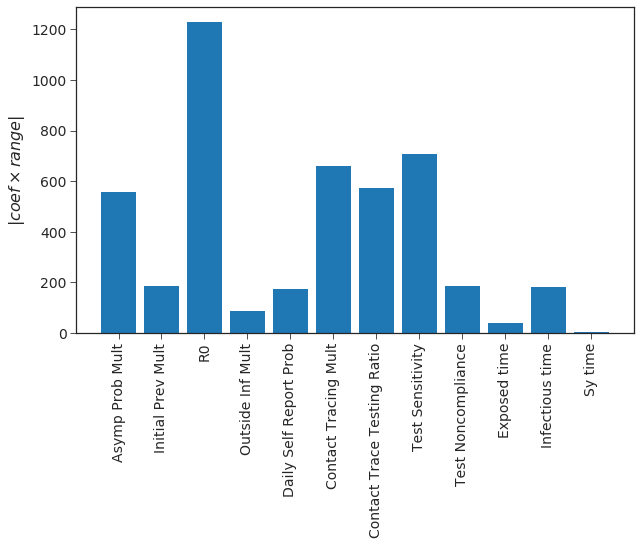

In [8]:
plt.figure(figsize=(10,6))
plt.bar(lr_summary_df.index[1:], np.abs(lr_summary_df['coef*range'])[1:])
# plt.ylabel('|coef * range|')
plt.ylabel(r"$\| coef \times range \|$")
# plt.xlabel('Feature')
# plt.xticks(rotation = 90)
plt.xticks(list(range(len(UNCERTAINTY_PARAMS_LIST[:12]))), ['Asymp Prob Mult', 'Initial Prev Mult', 'R0', 'Outside Inf Mult',
                                          'Daily Self Report Prob', 'Contact Tracing Mult', 'Contact Trace Testing Ratio',
                                          'Test Sensitivity', 'Test Noncompliance', 'Exposed time', 'Infectious time',
                                          'Sy time'], rotation=90)

plt.show()

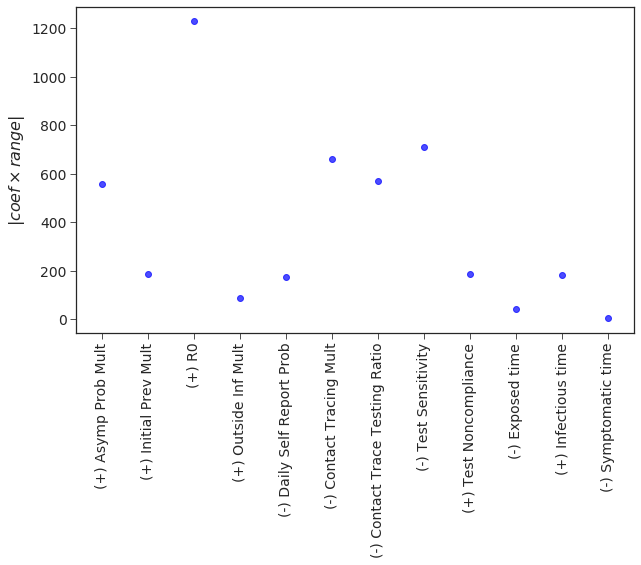

In [10]:
plt.figure(figsize=(10,6))

plt.scatter(x=lr_summary_df.index[1:], y=np.abs(lr_summary_df['coef*range'])[1:], label='Center', c='blue', alpha=0.7)
# plt.errorbar(x=lr_summary_df.index[1:], y=np.abs(lr_summary_df['coef*range'])[1:], yerr = 1.96/2 * np.array(lr_summary_df['std err*range'])[1:], fmt='o', label='Center', c='blue', alpha=0.7)

# plt.bar(lr_summary_df.index[1:], )
# plt.ylabel('|coef * range|')
plt.ylabel(r"$\| coef \times range \|$")
# plt.xlabel('Feature')
# plt.xticks(rotation = 90)
plt.xticks(list(range(len(UNCERTAINTY_PARAMS_LIST[:12]))), ['(+) Asymp Prob Mult', '(+) Initial Prev Mult', '(+) R0', '(+) Outside Inf Mult',
                                          '(-) Daily Self Report Prob', '(-) Contact Tracing Mult', '(-) Contact Trace Testing Ratio',
                                          '(-) Test Sensitivity', '(+) Test Noncompliance', '(-) Exposed time', '(+) Infectious time', '(-) Symptomatic time'], rotation=90)

plt.show()

In [19]:
1.96/2 * np.array(lr_summary_df['std err*range'])[1:]

array([58.47739234, 58.58734   , 58.4619    , 58.32862   , 58.4406144 ,
       58.42564   , 58.41094   , 58.501296  , 58.44916   , 58.43936   ,
       58.36488   , 58.35312   ])

In [12]:
def normalize_param(param_name, value):
    lower_bound = PARAM_BOUNDS[param_name][0]
    upper_bound = PARAM_BOUNDS[param_name][1]
    return (value - lower_bound) / (upper_bound - lower_bound)

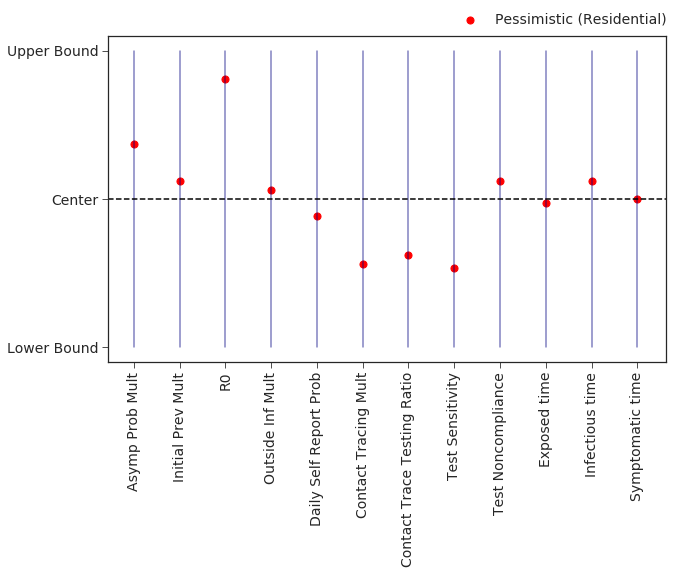

In [13]:
plt.figure(figsize=(10,6))
label = True

for index, param in enumerate(UNCERTAINTY_PARAMS_LIST[:12]):
    plt.plot([index, index], [0,1], color='navy', alpha=0.5)
    if label == True:
        plt.scatter(index, normalize_param(param, res_pessimistic[param]), color='red', label='Pessimistic (Residential)', s=50)
        label = False
    else:
        plt.scatter(index, normalize_param(param, res_pessimistic[param]), color='red', s=50)

plt.axhline(0.5, color='black', ls='--')

plt.xticks(list(range(len(UNCERTAINTY_PARAMS_LIST[:12]))), ['Asymp Prob Mult', 'Initial Prev Mult', 'R0', 'Outside Inf Mult',
                                          'Daily Self Report Prob', 'Contact Tracing Mult', 'Contact Trace Testing Ratio',
                                          'Test Sensitivity', 'Test Noncompliance', 'Exposed time', 'Infectious time', 'Symptomatic time'])
plt.xticks(rotation = 90)
plt.yticks([0,0.5,1], ['Lower Bound', 'Center', 'Upper Bound'])

# plt.xlabel('Parameter')
# plt.ylabel('Value')

plt.legend(bbox_to_anchor=(0.6,1.11), loc="upper left")
plt.show()

In [10]:
res_pessimistic, PARAM_BOUNDS

({'ct_testing_ratio': 0.8408882933907234,
  'outside_inf_mult': 1.0241384070908397,
  'E_time': 1.9781058849148887,
  'ct_mult': 1.3162323939656833,
  'ID_time': 3.1001602001642996,
  'R0': 3.525611538430936,
  'daily_self_report_prob': 0.34639409513141284,
  'test_noncompliance': 0.10516921933568774,
  'asymp_prob_mult': 1.1522097816900698,
  'Sy_time': 11.99746235017504,
  'test_sensitivity': 0.5210403803934798,
  'inital_prev_mult': 1.0513769799456971,
  'virtual_noncompliance': 0.5,
  'intermittent_non-compliance': 0.5,
  'virtual_r0_mult': 1.2349999999999999,
  'virtual_pop_size': 0.5},
 {'asymp_prob_mult': (0.5106382978723404, 1.4893617021276595),
  'inital_prev_mult': (0.5, 1.5),
  'R0': (1, 4),
  'outside_inf_mult': (0.5, 1.5),
  'daily_self_report_prob': (0.22, 0.5),
  'ct_mult': (1, 2),
  'ct_testing_ratio': (0.5, 1.5),
  'test_sensitivity': (0.4, 0.8),
  'test_noncompliance': (0.05, 0.15),
  'E_time': (1, 3),
  'ID_time': (2, 4),
  'Sy_time': (11, 13),
  'virtual_noncomplian

# Res - Vir Infections

In [14]:
scenario_data = load_sim_output(lhs_output_sim_files)
vir_results = virtual_vs_residential_regression(scenario_data)
vir_pessimistic = calculate_pessimistic_scenario(vir_results)
vir_pessimistic['const'] = 0

In [15]:
vir_pessimistic

{'ct_mult': 1.5590725867456006,
 'virtual_pop_size': 0.4250160047352576,
 'Sy_time': 11.935000269774681,
 'ct_testing_ratio': 1.0057420388371117,
 'virtual_noncompliance': 0.44605096865303384,
 'E_time': 1.993897515453085,
 'test_sensitivity': 0.6018377311456834,
 'virtual_r0_mult': 1.1386404664682888,
 'R0': 1.1059915332875805,
 'outside_inf_mult': 1.0003798027370396,
 'daily_self_report_prob': 0.3728841846082932,
 'inital_prev_mult': 0.9925614764285442,
 'test_noncompliance': 0.10172033202180288,
 'asymp_prob_mult': 0.7416890477835014,
 'ID_time': 2.866272190540004,
 'intermittent_non-compliance': 0.4655513678494027,
 'const': 0}

In [16]:
vir_results_summary = vir_results.summary()
vir_results_as_html = vir_results_summary.tables[1].as_html()
vir_lr_summary_df = pd.read_html(vir_results_as_html, header=0, index_col=0)[0]
vir_lr_summary_df
# lr_summary_df['coef'], coef_normalized

coef   std err       t  P>|t|     [0.025  \
const                        19870.0000   827.543  24.016  0.000  18300.000   
asymp_prob_mult              -4341.5386   109.323 -39.713  0.000  -4555.938   
inital_prev_mult              -119.7588   106.855  -1.121  0.263   -329.318   
R0                           -2493.6971    35.583 -70.082  0.000  -2563.480   
outside_inf_mult                 6.1148   106.662   0.057  0.954   -203.066   
daily_self_report_prob        2645.8284   380.648   6.951  0.000   1899.316   
ct_mult                        951.0575   106.562   8.925  0.000    742.072   
ct_testing_ratio                92.4457   106.752   0.866  0.387   -116.912   
test_sensitivity               184.9195   266.984   0.693  0.489   -338.679   
test_noncompliance            2769.7022  1066.233   2.598  0.009    678.647   
E_time                         -24.5622    53.291  -0.461  0.645   -129.074   
ID_time                       -538.2481    53.218 -10.114  0.000   -642.617   
Sy_time                       -261.6209    53.268  -4.911  0.000   -366.088   
virtual_noncompliance        -3474.2770   213.411 -16.280  0.000  -3892.810   
intermittent_non-compliance  -2218.4660   213.020 -10.414  0.000  -2636.233   
virtual_r0_mult              -5522.8563   201.002 -27.477  0.000  -5917.053   
virtual_pop_size             -1207.2282   106.898 -11.293  0.000  -1416.872   

                                0.975]  
const                        21500.000  
asymp_prob_mult              -4127.139  
inital_prev_mult                89.800  
R0                           -2423.914  
outside_inf_mult               215.296  
daily_self_report_prob        3392.341  
ct_mult                       1160.043  
ct_testing_ratio               301.803  
test_sensitivity               708.518  
test_noncompliance            4860.757  
E_time                          79.950  
ID_time                       -433.879  
Sy_time                       -157.154  
virtual_noncompliance        -3055.744  
intermittent_non-compliance  -1800.699  
virtual_r0_mult              -5128.660  
virtual_pop_size              -997.584

In [17]:
results_summary = vir_results.summary()
results_as_html = results_summary.tables[1].as_html()
lr_summary_df = pd.read_html(results_as_html, header=0, index_col=0)[0]

coef_normalized = list()
for param, value in dict(lr_summary_df['coef']).items():
    if param == 'const':
        coef_normalized.append(value)
        continue
    param_range = PARAM_BOUNDS[param][1] - PARAM_BOUNDS[param][0]
    coef_normalized.append(value * param_range)
    
# std_err_normalized = list()
# for param, value in dict(lr_summary_df['std err']).items():
#     if param == 'const':
#         std_err_normalized.append(value)
#         continue
#     param_range = PARAM_BOUNDS[param][1] - PARAM_BOUNDS[param][0]
#     std_err_normalized.append(value * param_range)


lr_summary_df['coef*range'] = coef_normalized
# lr_summary_df['std err*range'] = std_err_normalized
# lr_summary_df['pess value'] = res_pessimistic

In [18]:
# lr_summary_df.columns
lr_summary_df[['coef', 'std err', 'P>|t|', 'coef*range']].round(3)

coef   std err  P>|t|  coef*range
const                        19870.000   827.543  0.000   19870.000
asymp_prob_mult              -4341.539   109.323  0.000   -4249.165
inital_prev_mult              -119.759   106.855  0.263    -119.759
R0                           -2493.697    35.583  0.000   -7481.091
outside_inf_mult                 6.115   106.662  0.954       6.115
daily_self_report_prob        2645.828   380.648  0.000     740.832
ct_mult                        951.058   106.562  0.000     951.058
ct_testing_ratio                92.446   106.752  0.387      92.446
test_sensitivity               184.920   266.984  0.489      73.968
test_noncompliance            2769.702  1066.233  0.009     276.970
E_time                         -24.562    53.291  0.645     -49.124
ID_time                       -538.248    53.218  0.000   -1076.496
Sy_time                       -261.621    53.268  0.000    -523.242
virtual_noncompliance        -3474.277   213.411  0.000   -1737.138
intermittent_non-compliance  -2218.466   213.020  0.000   -1109.233
virtual_r0_mult              -5522.856   201.002  0.000   -2927.114
virtual_pop_size             -1207.228   106.898  0.000   -1207.228

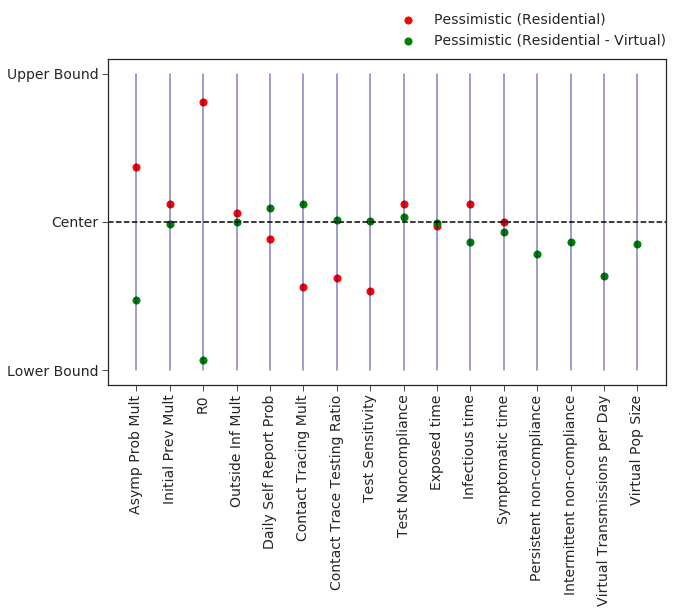

In [19]:
plt.figure(figsize=(10,6))
label = True

for index, param in enumerate(UNCERTAINTY_PARAMS_LIST[:12]):
    if label == True:
        plt.scatter(index, normalize_param(param, res_pessimistic[param]), color='red', label='Pessimistic (Residential)', s=50)
        label = False
    else:
        plt.scatter(index, normalize_param(param, res_pessimistic[param]), color='red', s=50)

label=True
for index, param in enumerate(UNCERTAINTY_PARAMS_LIST):
    plt.plot([index, index], [0,1], color='navy', alpha=0.5)
    if label == True:
        plt.scatter(index, normalize_param(param, vir_pessimistic[param]), color='green', label='Pessimistic (Residential - Virtual)', s=50)
        label = False
    else:
        plt.scatter(index, normalize_param(param, vir_pessimistic[param]), color='green', s=50)
        

plt.axhline(0.5, color='black', ls='--')

plt.xticks(list(range(len(UNCERTAINTY_PARAMS_LIST))), ['Asymp Prob Mult', 'Initial Prev Mult', 'R0', 'Outside Inf Mult',
                                          'Daily Self Report Prob', 'Contact Tracing Mult', 'Contact Trace Testing Ratio',
                                          'Test Sensitivity', 'Test Noncompliance', 'Exposed time', 'Infectious time', 'Symptomatic time',
                                          'Persistent non-compliance', 'Intermittent non-compliance',
                                          'Virtual Transmissions per Day', 'Virtual Pop Size'])
plt.xticks(rotation = 90)
plt.yticks([0,0.5,1], ['Lower Bound', 'Center', 'Upper Bound'])

# plt.xlabel('Parameter')
# plt.ylabel('Value')

plt.legend(bbox_to_anchor=(0.49,1.18), loc="upper left")
plt.show()

### Quality of Fit

In [8]:
results_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     70.74
Date:                Fri, 10 Sep 2021   Prob (F-statistic):          6.53e-144
Time:                        13:30:41   Log-Likelihood:                -16117.
No. Observations:                2000   AIC:                         3.226e+04
Df Residuals:                    1987   BIC:                         3.233e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   1014.7360    429.208      2.364      0.018     172.992    1856.480
asymp_prob_mult          570.4510     60.968      9.357      0.000     450.883     690.019
inital_prev_mult         184.4439     59.783      3.085      0.002      67.199     301.689
R0                       409.1062     19.885     20.574      0.000     370.109     448.104
outside_inf_mult          86.6571     59.519      1.456      0.146     -30.069     203.383
daily_self_report_prob  -623.0273    212.976     -2.925      0.003   -1040.708    -205.347
ct_mult                 -659.7276     59.618    -11.066      0.000    -776.647    -542.808
ct_testing_ratio        -571.2127     59.603     -9.584      0.000    -688.103    -454.322
test_sensitivity       -1771.6616    149.238    -11.871      0.000   -2064.341   -1478.982
test_noncompliance      1855.7551    596.420      3.111      0.002     686.080    3025.430
E_time                   -19.6500     29.816     -0.659      0.510     -78.124      38.824
ID_time                   89.8940     29.778      3.019      0.003      31.494     148.294
Sy_time                   -2.2775     29.772     -0.076      0.939     -60.665      56.110
==============================================================================
Omnibus:                     2160.376   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           143604.673
Skew:                           5.432   Prob(JB):                         0.00
Kurtosis:                      43.065   Cond. No.                         460.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
import statsmodels.api as sm

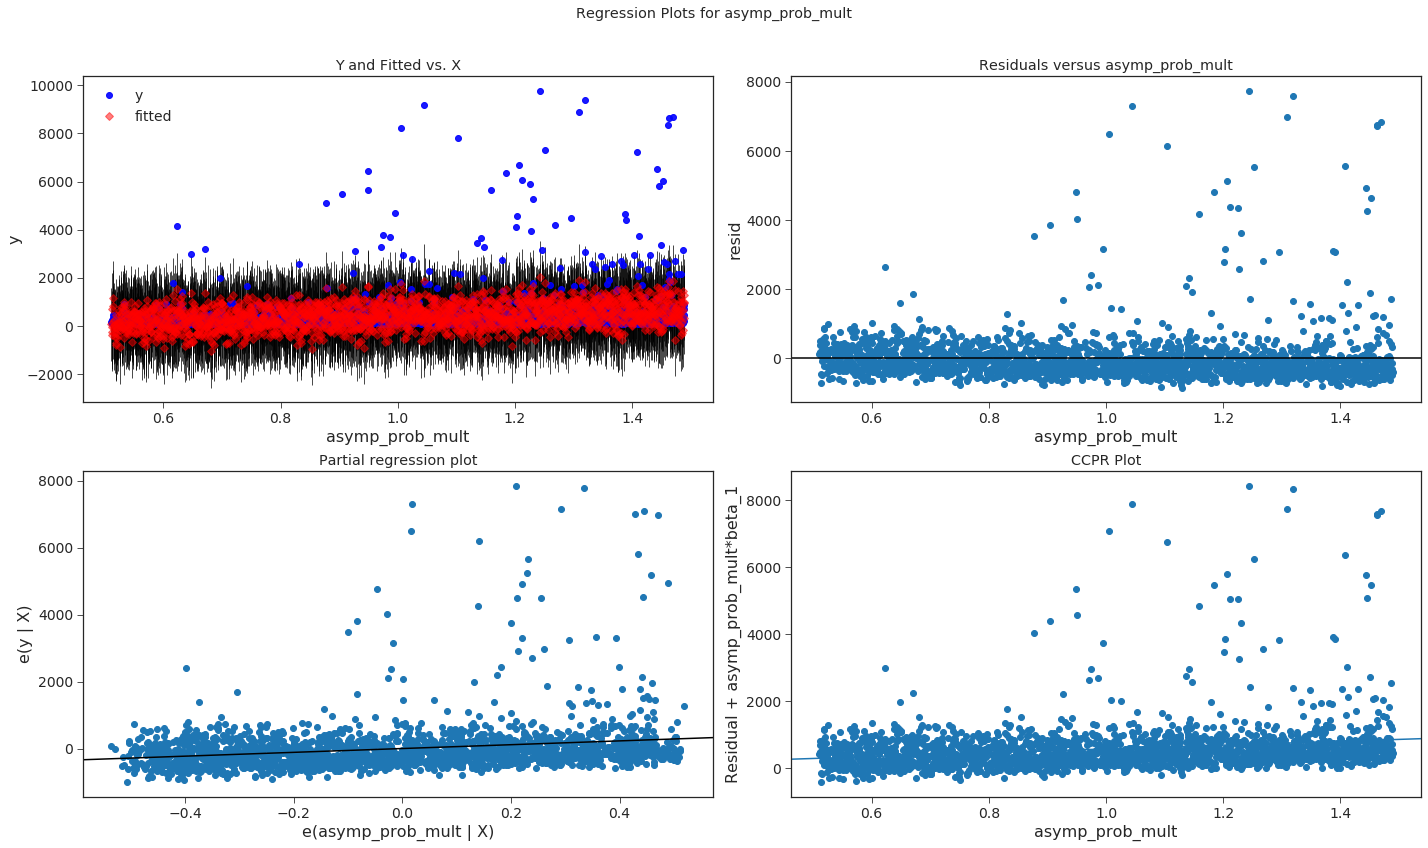

In [25]:
fig = plt.figure(figsize=(20, 12))
fig = sm.graphics.plot_regress_exog(res_results, "asymp_prob_mult", fig=fig)
plt.show()

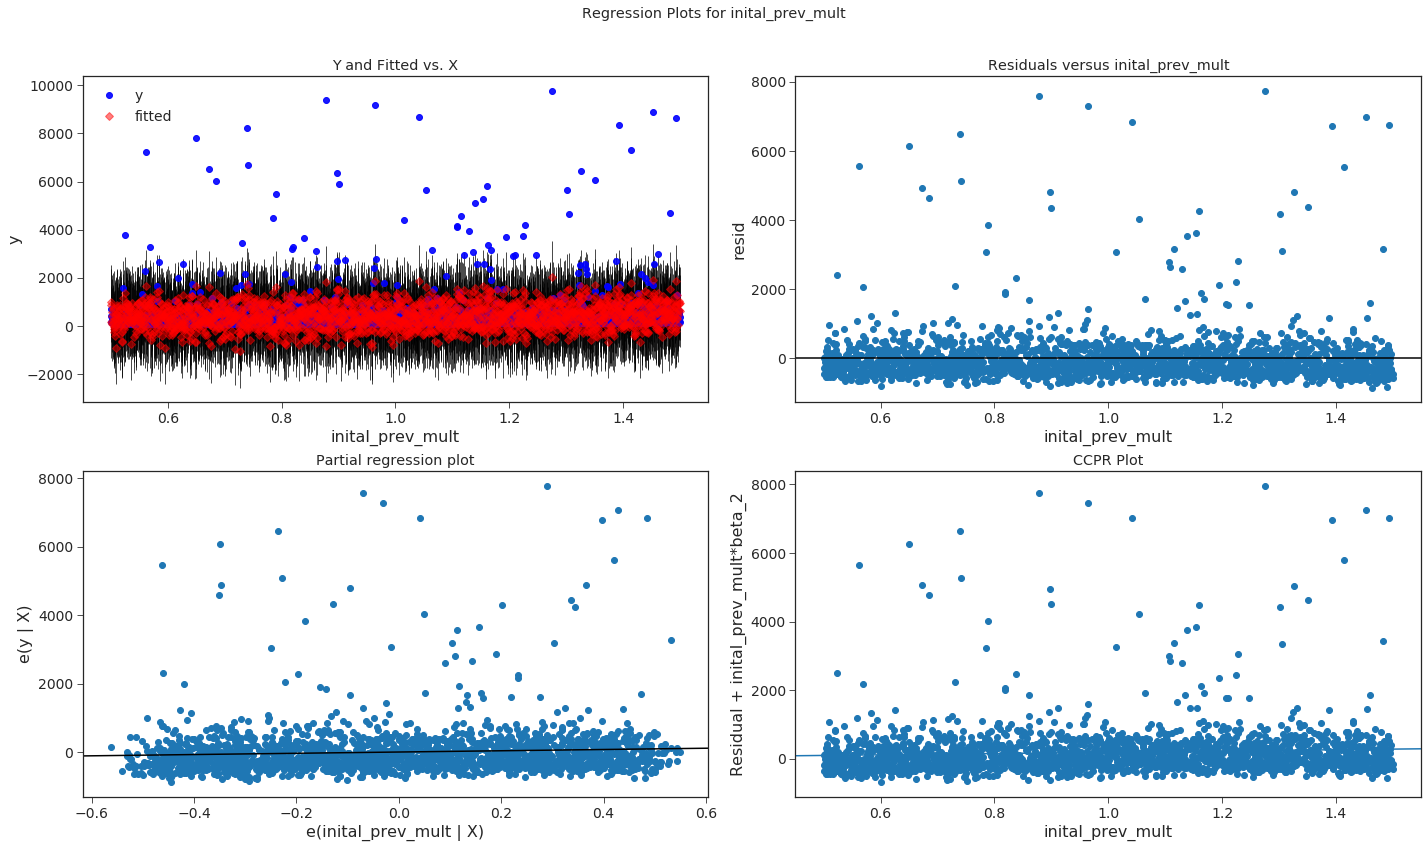

In [26]:
fig = plt.figure(figsize=(20, 12))
fig = sm.graphics.plot_regress_exog(res_results, "inital_prev_mult", fig=fig)
plt.show()

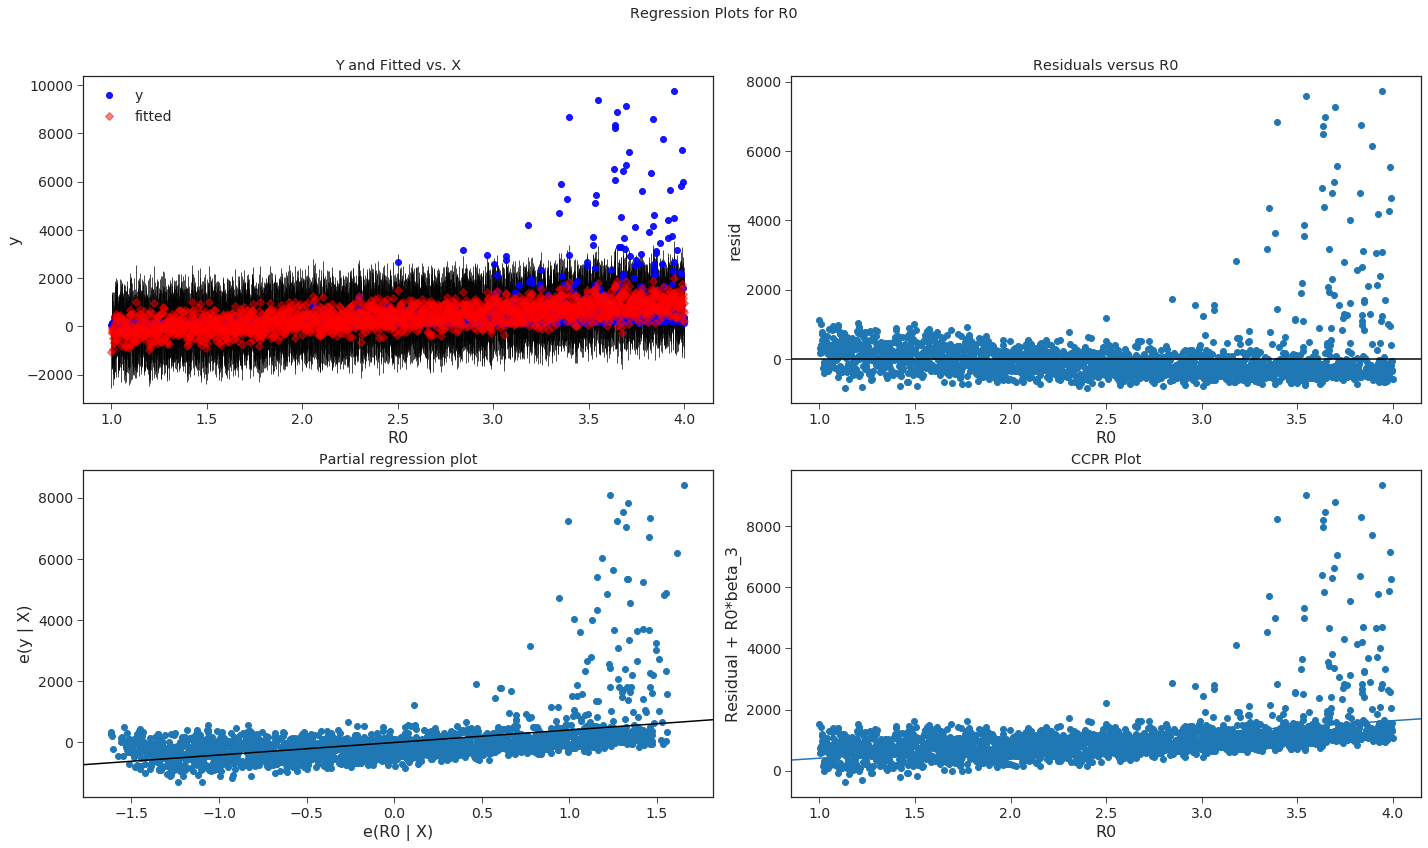

In [27]:
fig = plt.figure(figsize=(20, 12))
fig = sm.graphics.plot_regress_exog(res_results, "R0", fig=fig)
plt.show()

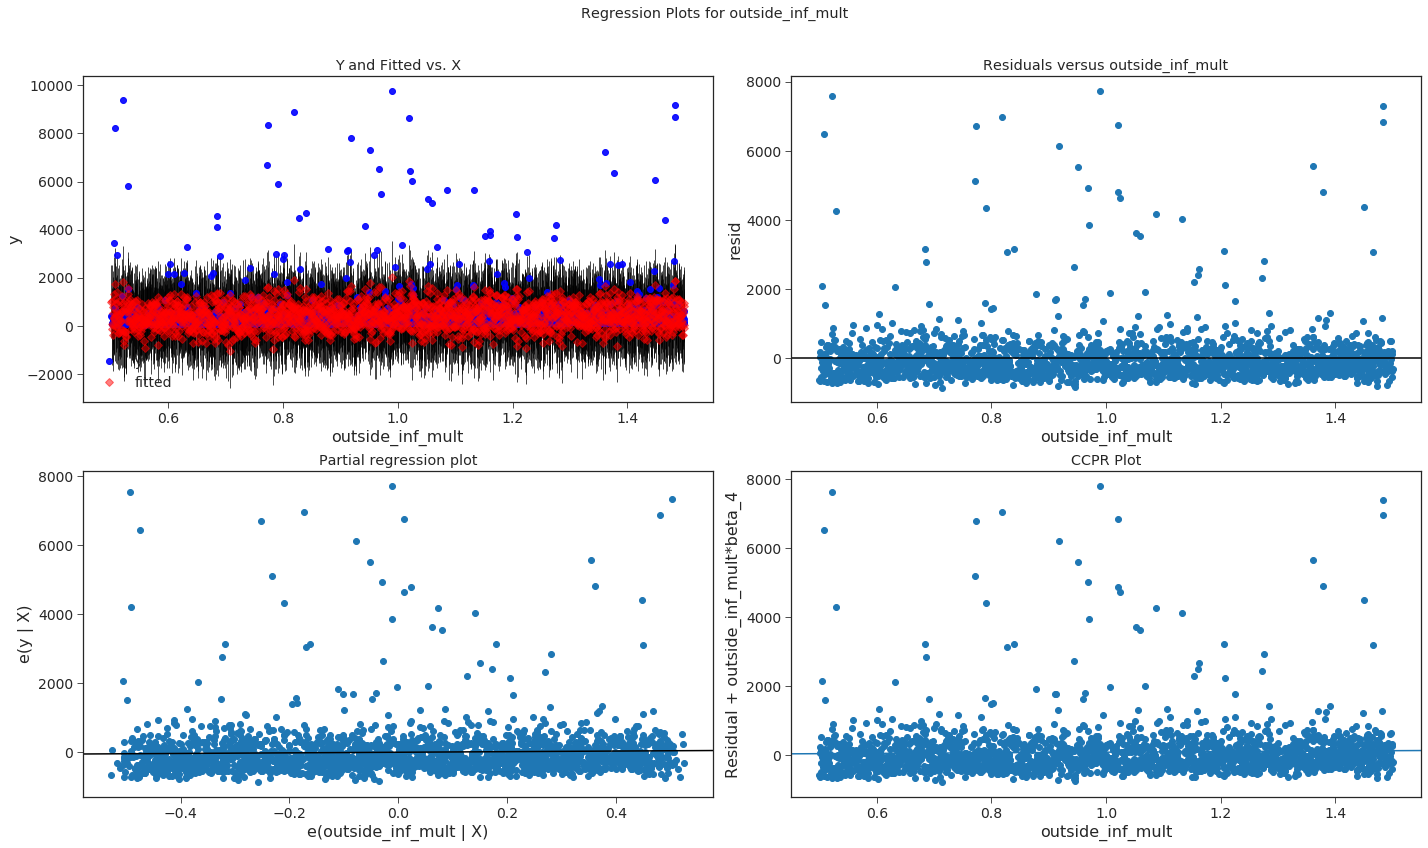

In [28]:
fig = plt.figure(figsize=(20, 12))
fig = sm.graphics.plot_regress_exog(res_results, "outside_inf_mult", fig=fig)
plt.show()

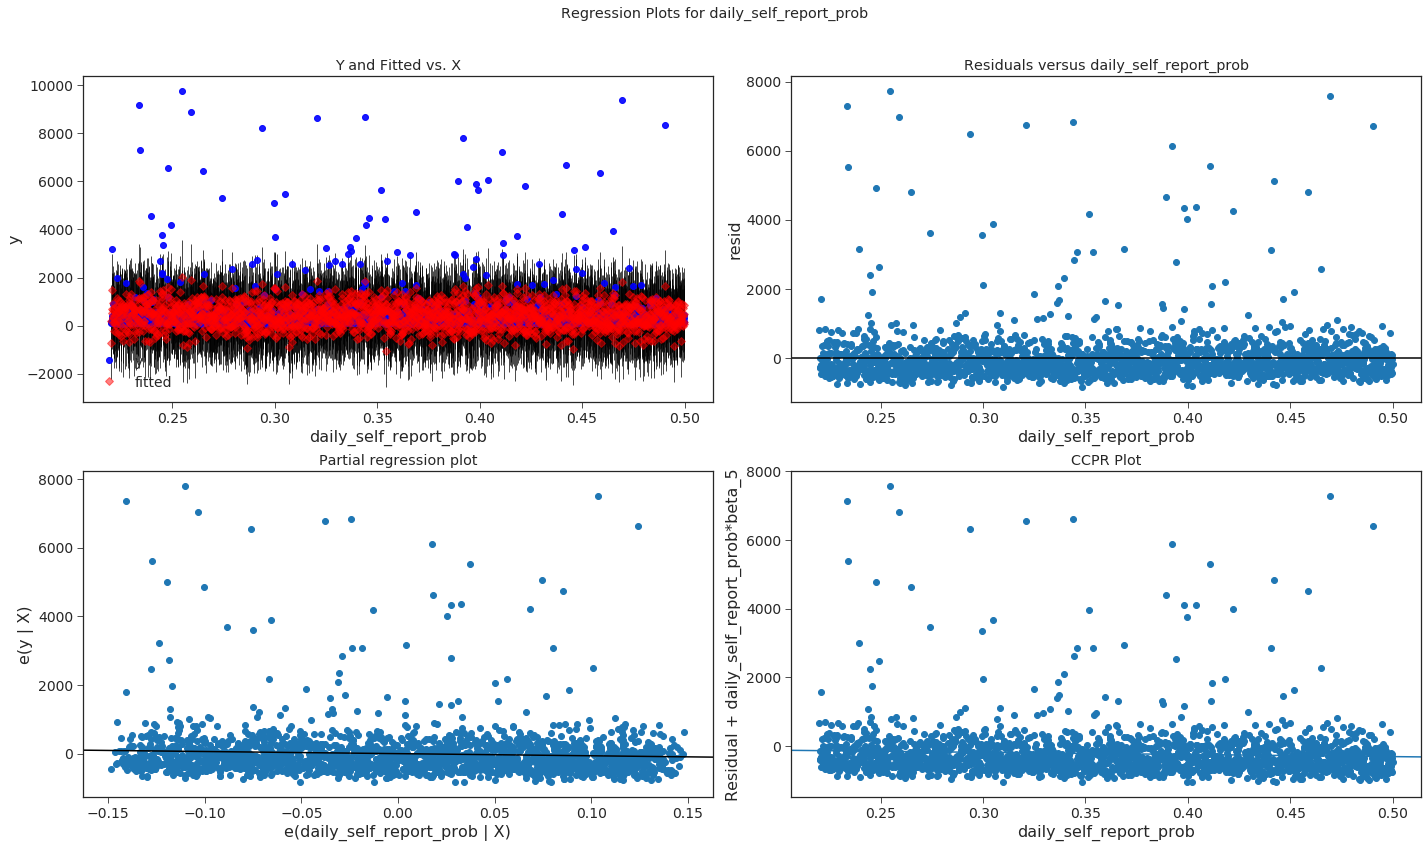

In [29]:
fig = plt.figure(figsize=(20, 12))
fig = sm.graphics.plot_regress_exog(res_results, "daily_self_report_prob", fig=fig)
plt.show()

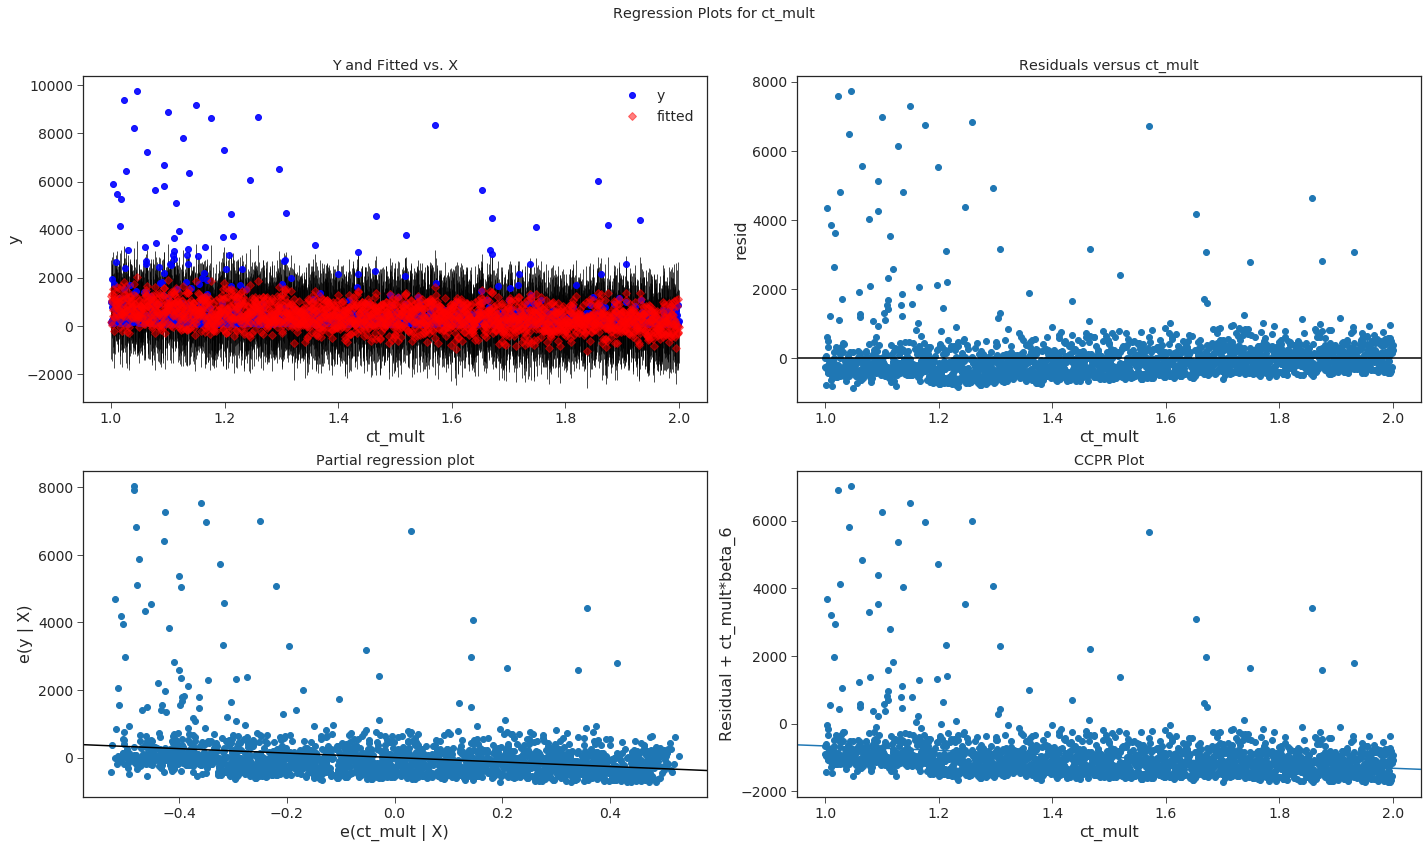

In [30]:
fig = plt.figure(figsize=(20, 12))
fig = sm.graphics.plot_regress_exog(res_results, "ct_mult", fig=fig)
plt.show()

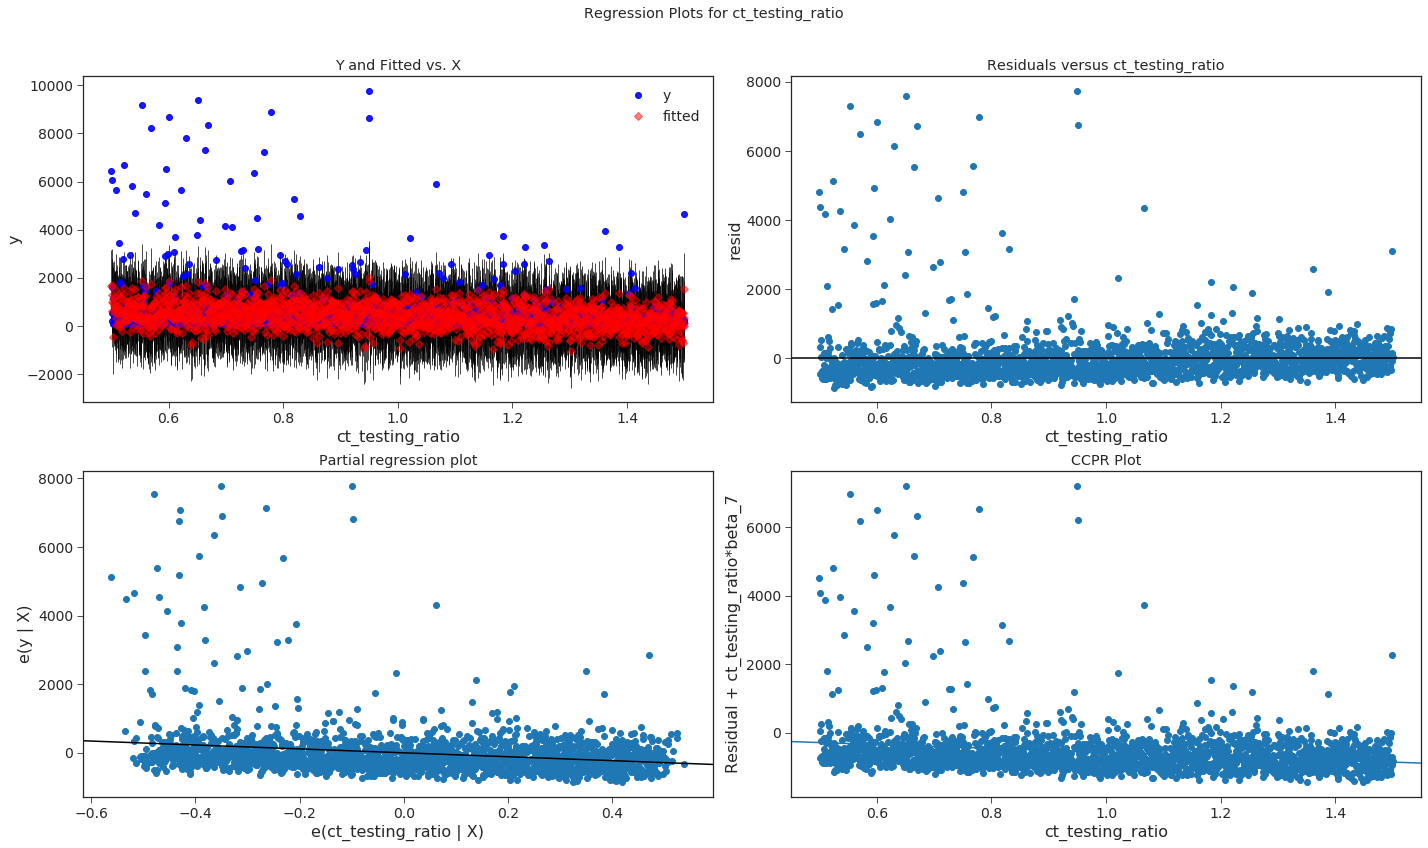

In [31]:
fig = plt.figure(figsize=(20, 12))
fig = sm.graphics.plot_regress_exog(res_results, "ct_testing_ratio", fig=fig)
plt.show()

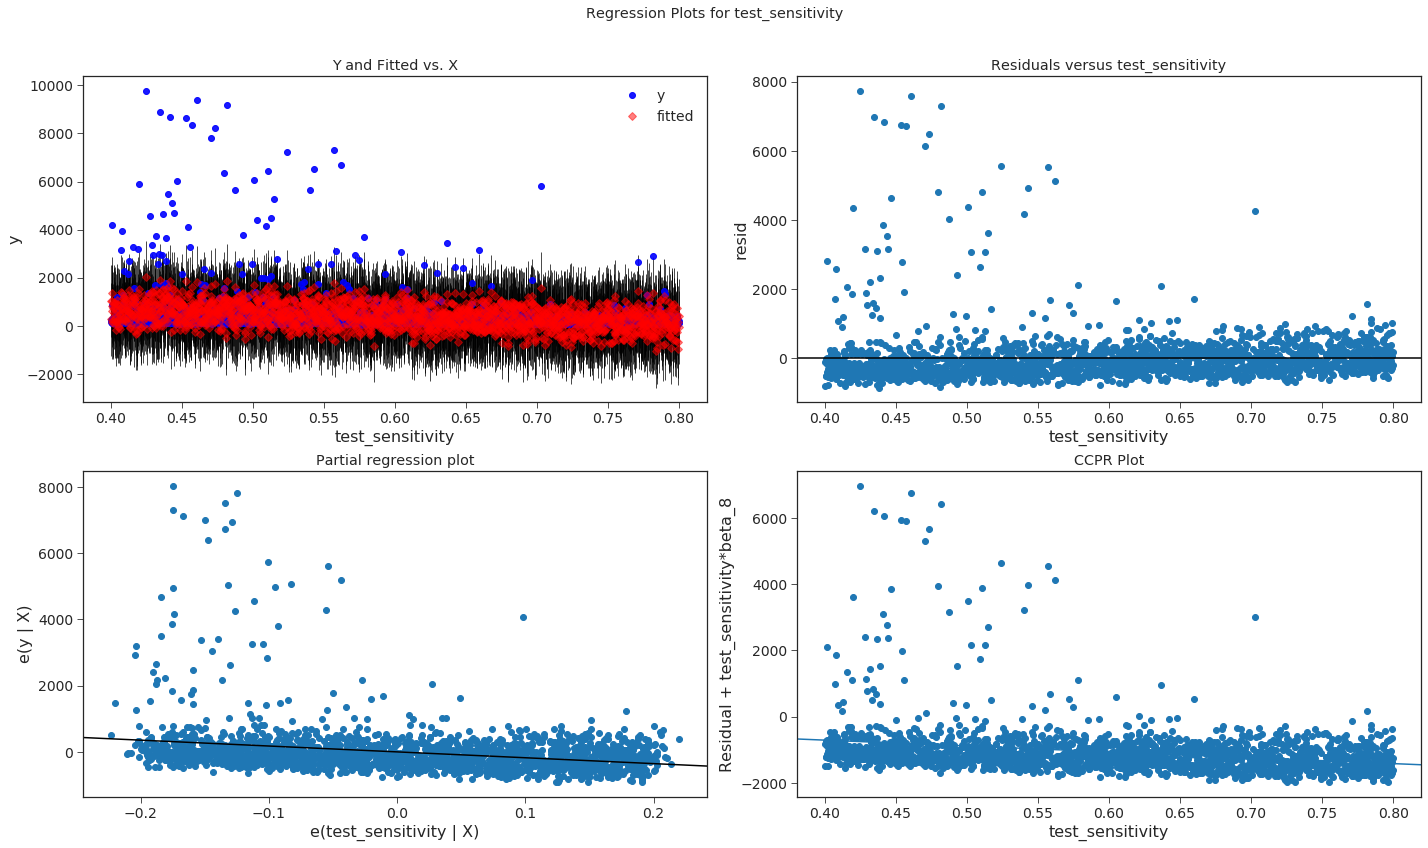

In [32]:
fig = plt.figure(figsize=(20, 12))
fig = sm.graphics.plot_regress_exog(res_results, "test_sensitivity", fig=fig)
plt.show()

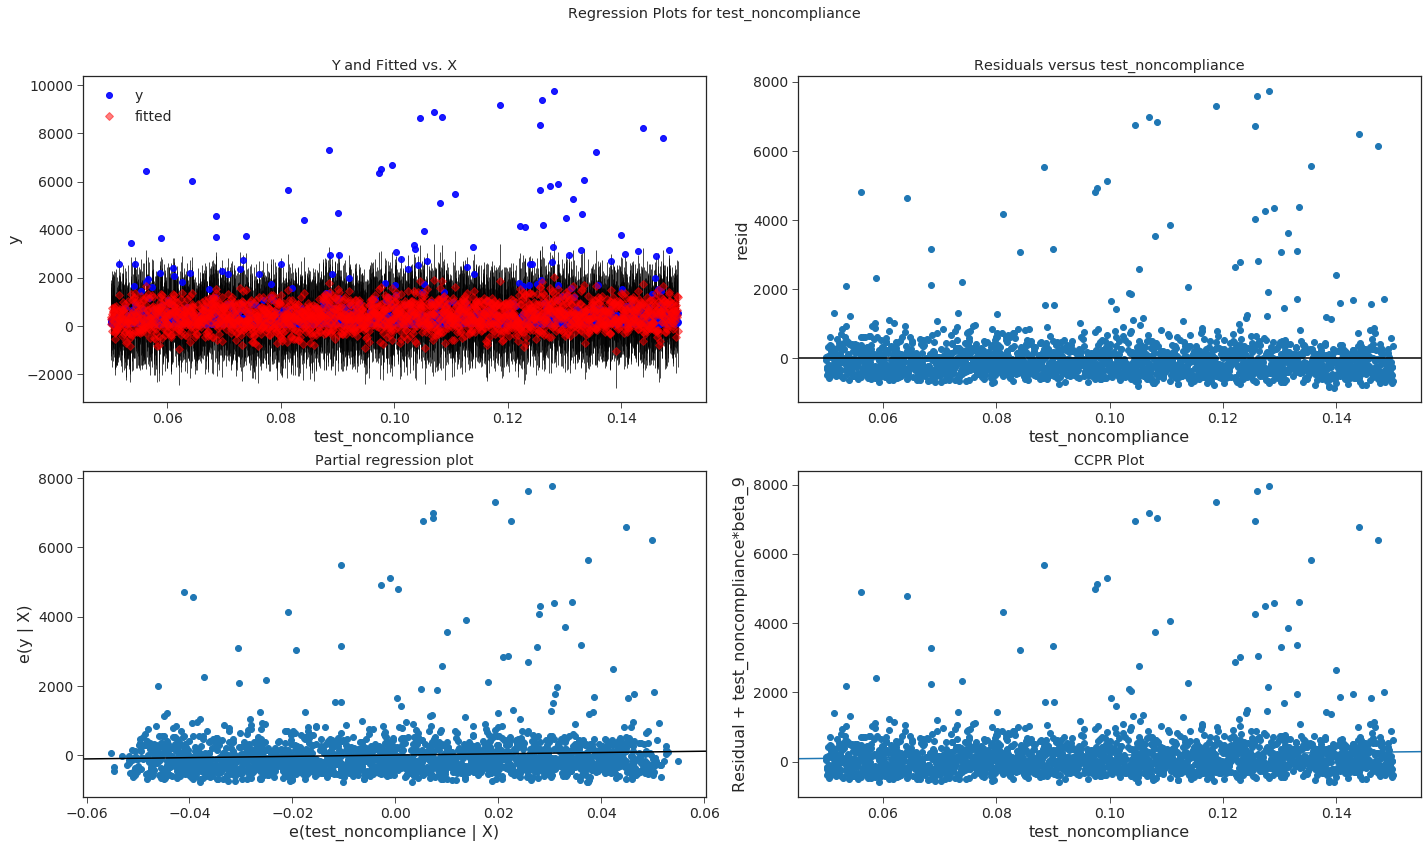

In [33]:
fig = plt.figure(figsize=(20, 12))
fig = sm.graphics.plot_regress_exog(res_results, "test_noncompliance", fig=fig)
plt.show()

### Quality of fit log(infections)

In [36]:
residential_columns = scenario_data.columns[0:12]
residential_target = 'res_cornell_inf_50'
X_res = scenario_data[residential_columns]
Y_res_outcomes = np.log(np.array(scenario_data[[residential_target]]))

X = add_constant(X_res)
model = OLS(Y_res_outcomes,X)
log_results = model.fit()

In [37]:
log_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     541.7
Date:                Fri, 10 Sep 2021   Prob (F-statistic):               0.00
Time:                        17:58:34   Log-Likelihood:                -1005.1
No. Observations:                2000   AIC:                             2036.
Df Residuals:                    1987   BIC:                             2109.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      4.7544      0.224     21.183      0.000       4.314       5.195
asymp_prob_mult            0.6785      0.032     21.282      0.000       0.616       0.741
inital_prev_mult           0.4394      0.031     14.054      0.000       0.378       0.501
R0                         0.6829      0.010     65.669      0.000       0.662       0.703
outside_inf_mult           0.4281      0.031     13.754      0.000       0.367       0.489
daily_self_report_prob    -0.8418      0.111     -7.558      0.000      -1.060      -0.623
ct_mult                   -0.7041      0.031    -22.585      0.000      -0.765      -0.643
ct_testing_ratio          -0.5536      0.031    -17.762      0.000      -0.615      -0.492
test_sensitivity          -2.0929      0.078    -26.818      0.000      -2.246      -1.940
test_noncompliance         1.5162      0.312      4.861      0.000       0.905       2.128
E_time                    -0.0086      0.016     -0.554      0.580      -0.039       0.022
ID_time                    0.1171      0.016      7.521      0.000       0.087       0.148
Sy_time                    0.0110      0.016      0.709      0.478      -0.019       0.042
==============================================================================
Omnibus:                      788.656   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3306.785
Skew:                           1.896   Prob(JB):                         0.00
Kurtosis:                       8.031   Cond. No.                         460.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

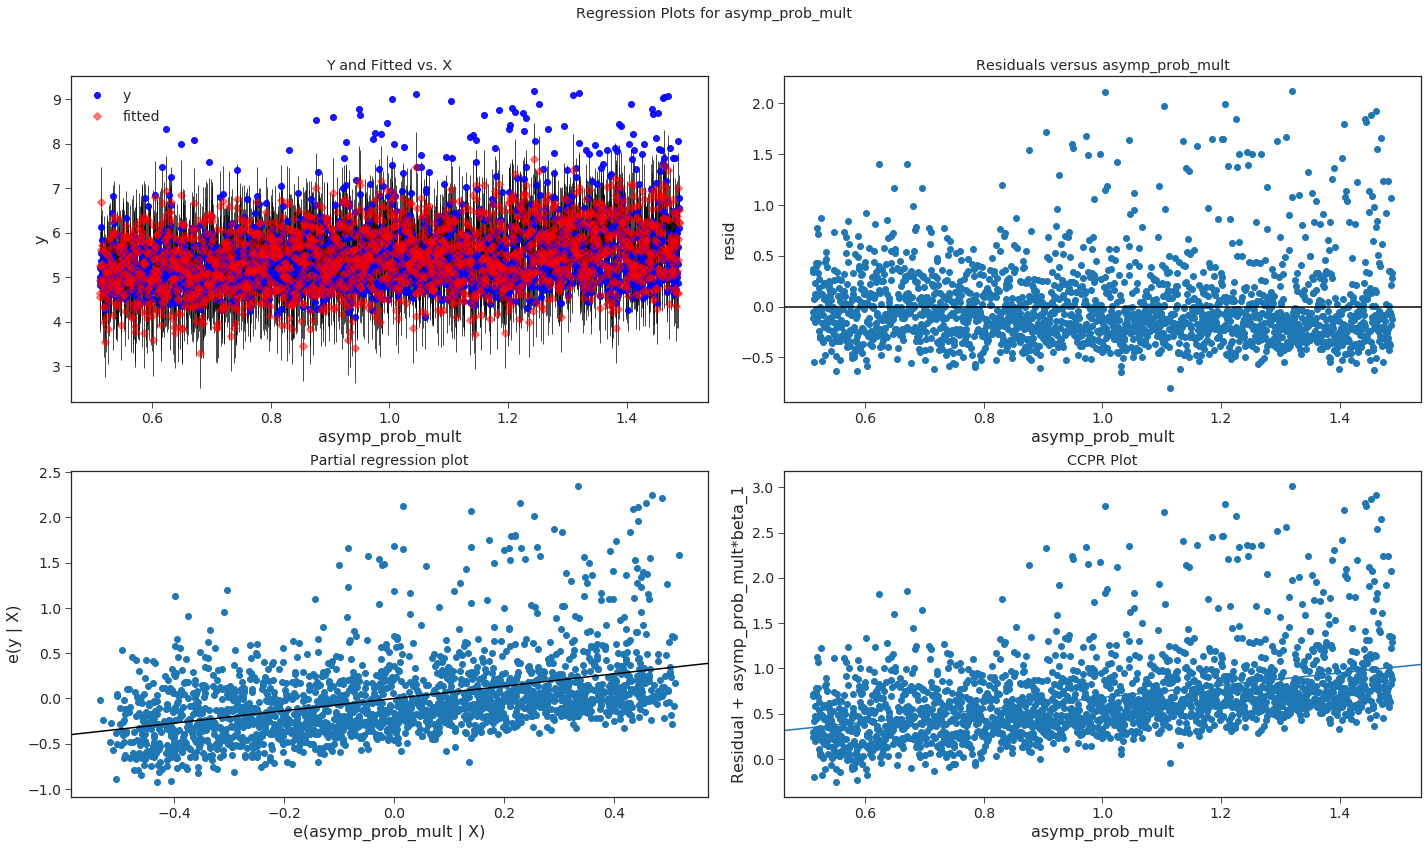

In [38]:
fig = plt.figure(figsize=(20, 12))
fig = sm.graphics.plot_regress_exog(log_results, "asymp_prob_mult", fig=fig)
plt.show()

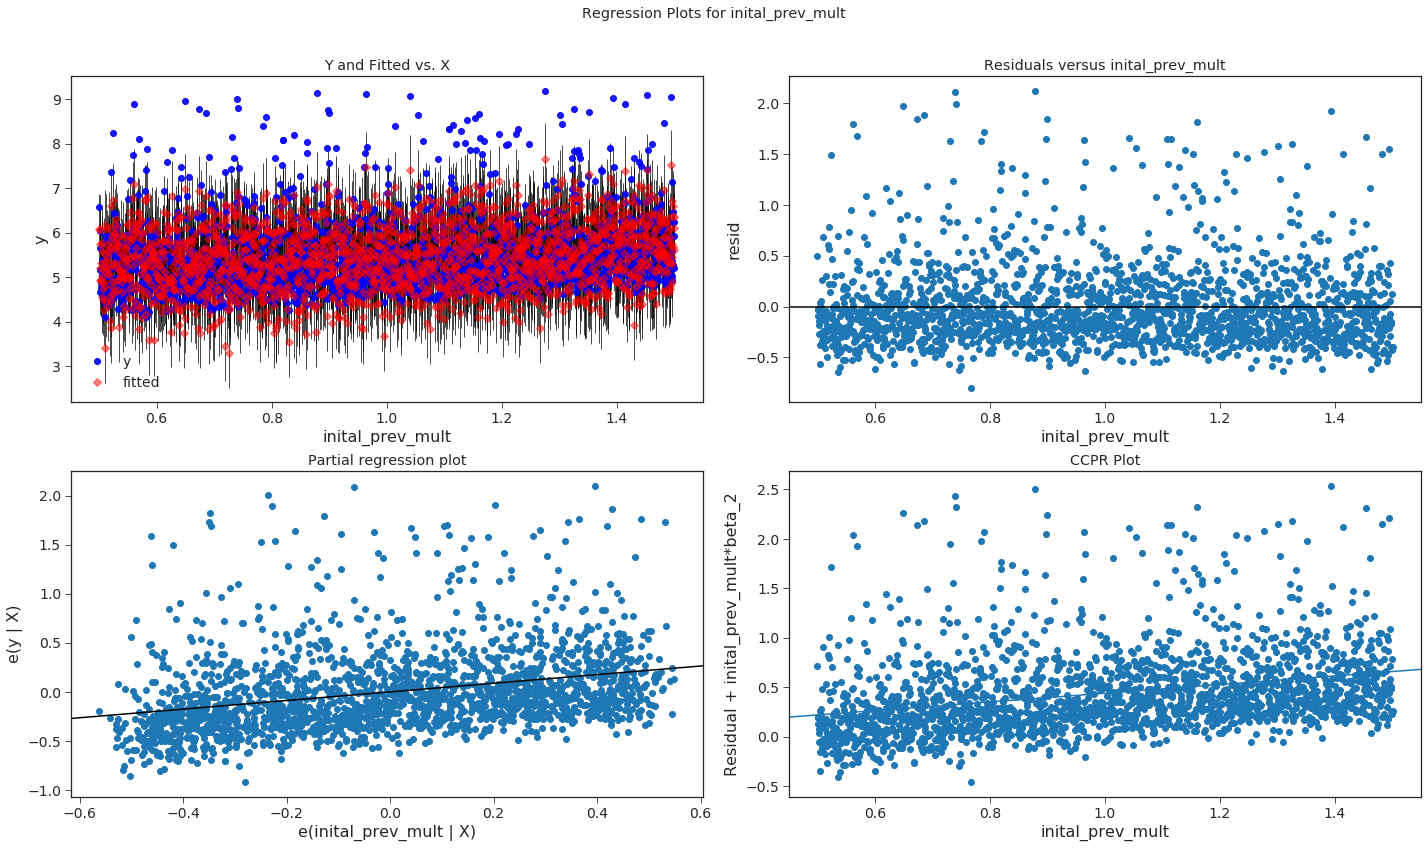

In [39]:
fig = plt.figure(figsize=(20, 12))
fig = sm.graphics.plot_regress_exog(log_results, "inital_prev_mult", fig=fig)
plt.show()

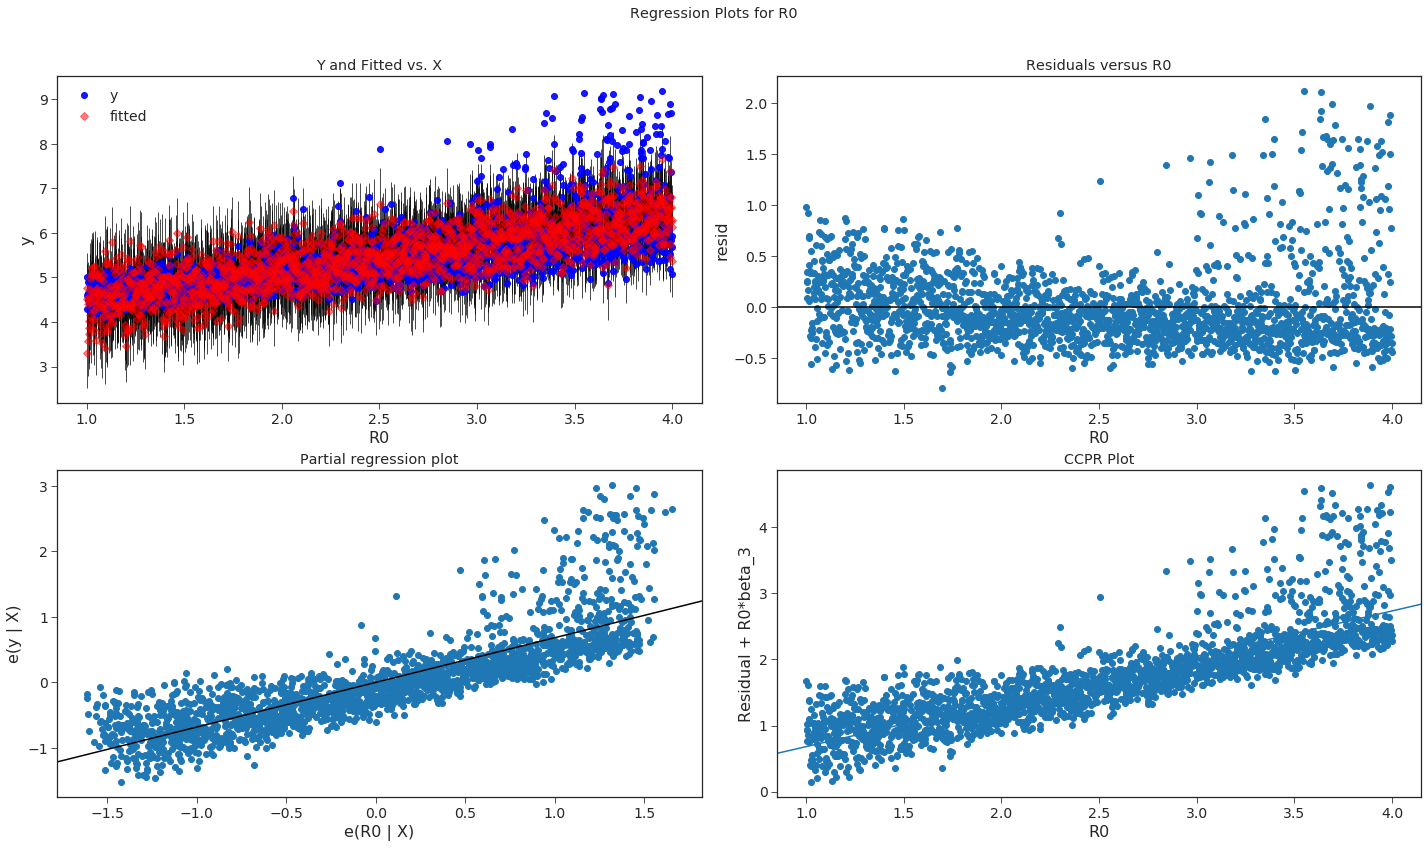

In [40]:
fig = plt.figure(figsize=(20, 12))
fig = sm.graphics.plot_regress_exog(log_results, "R0", fig=fig)
plt.show()

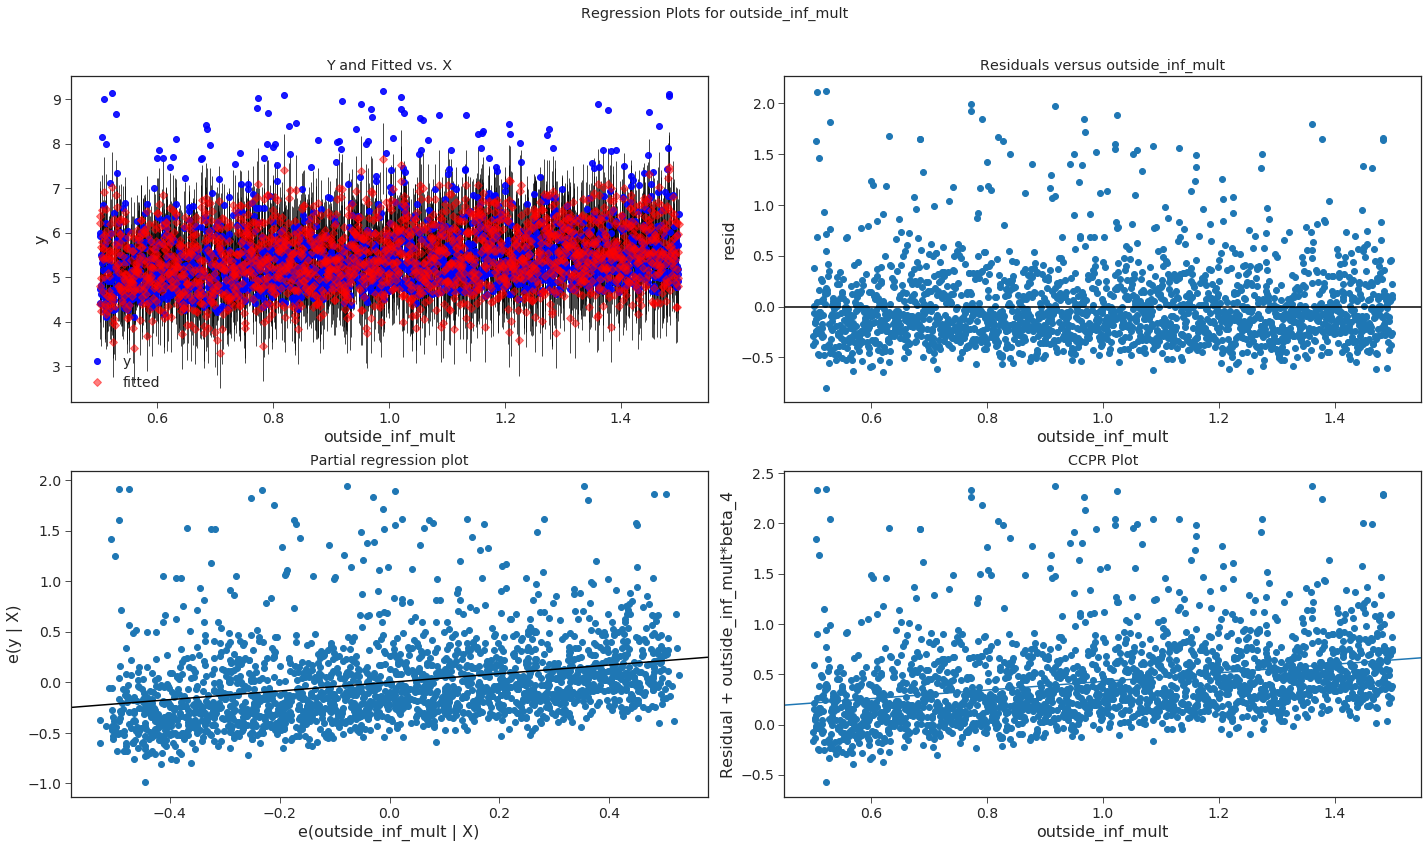

In [41]:
fig = plt.figure(figsize=(20, 12))
fig = sm.graphics.plot_regress_exog(log_results, "outside_inf_mult", fig=fig)
plt.show()

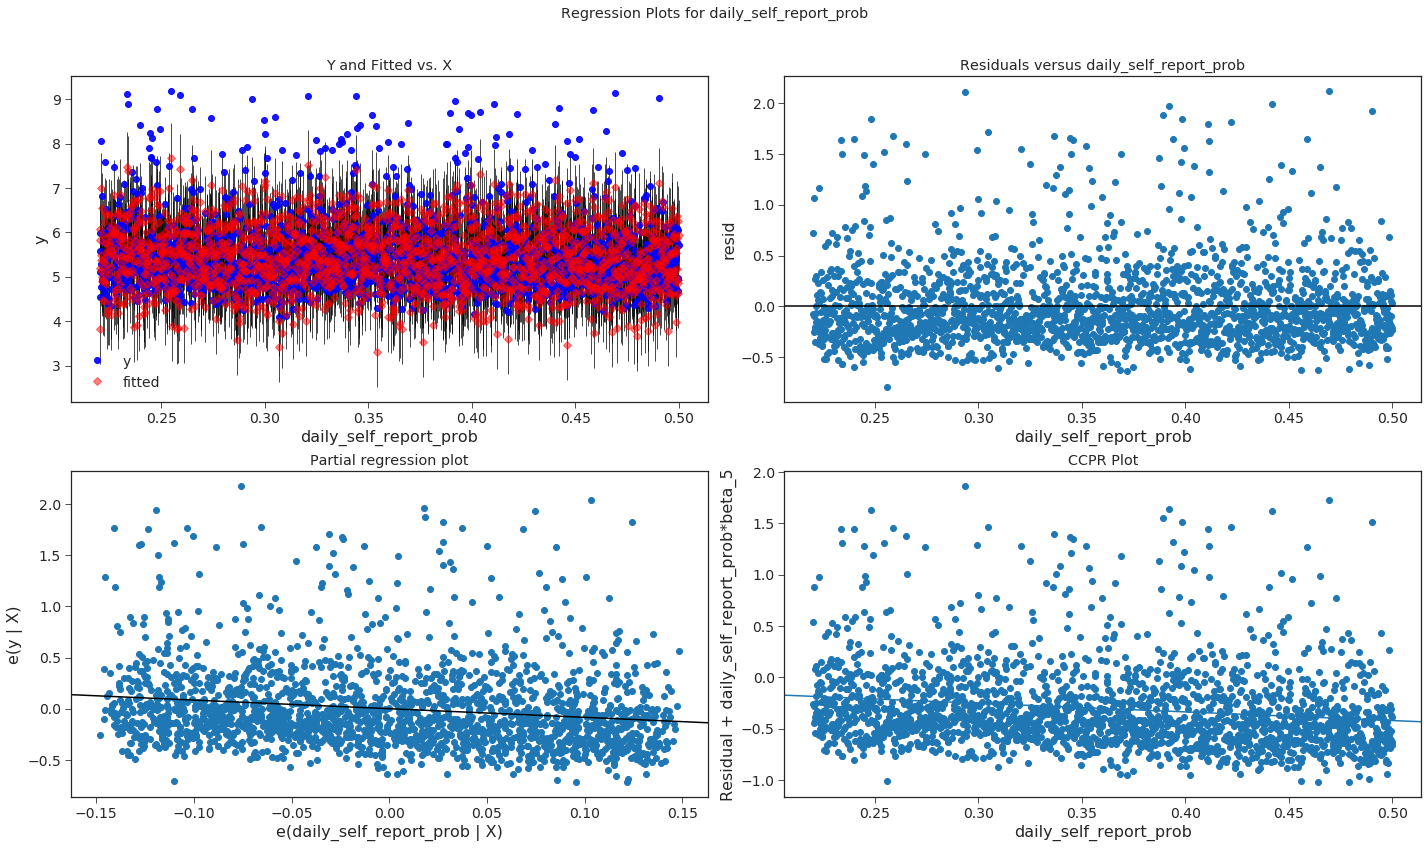

In [42]:
fig = plt.figure(figsize=(20, 12))
fig = sm.graphics.plot_regress_exog(log_results, "daily_self_report_prob", fig=fig)
plt.show()

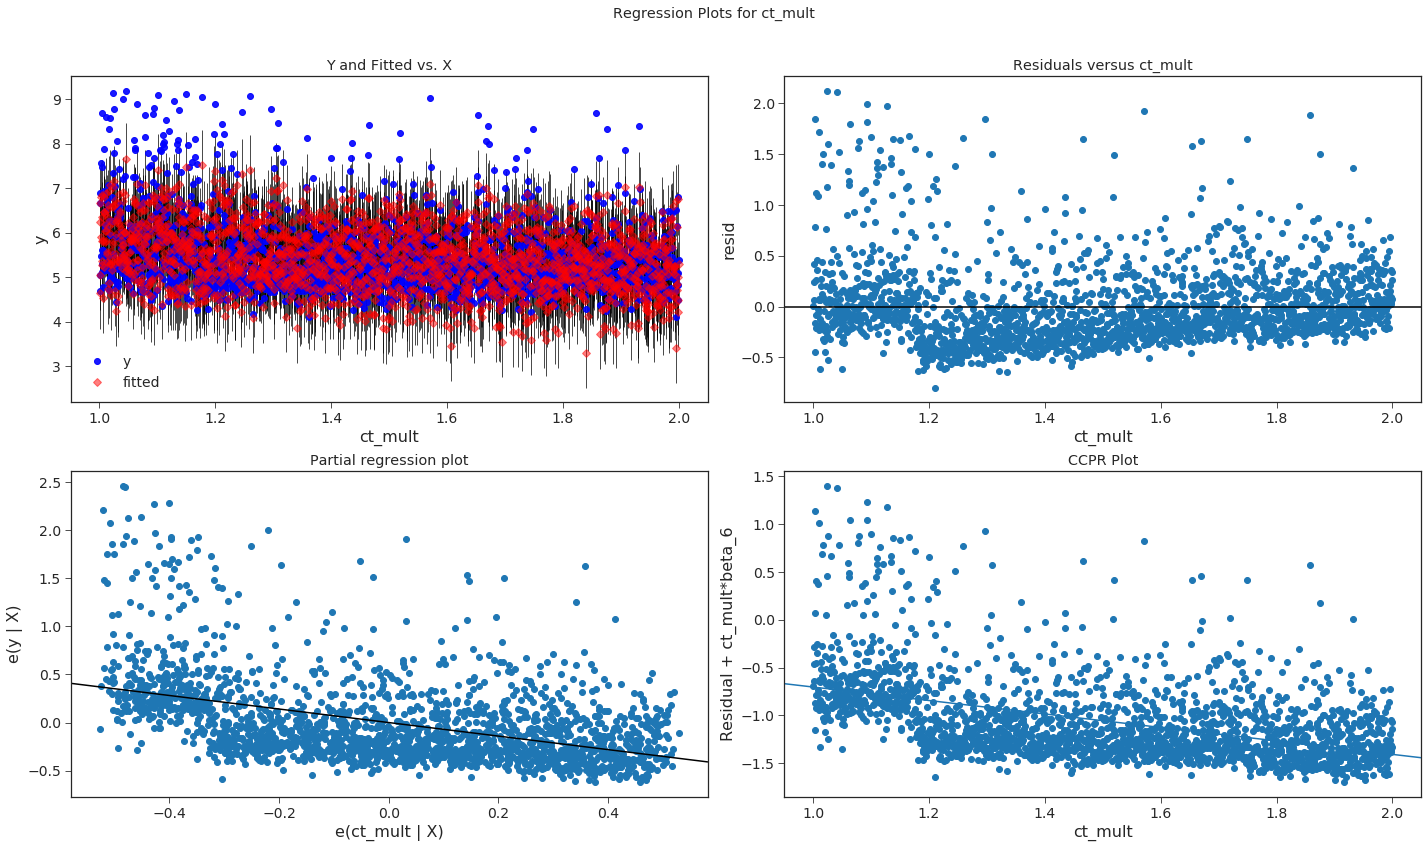

In [44]:
fig = plt.figure(figsize=(20, 12))
fig = sm.graphics.plot_regress_exog(log_results, "ct_mult", fig=fig)
plt.show()

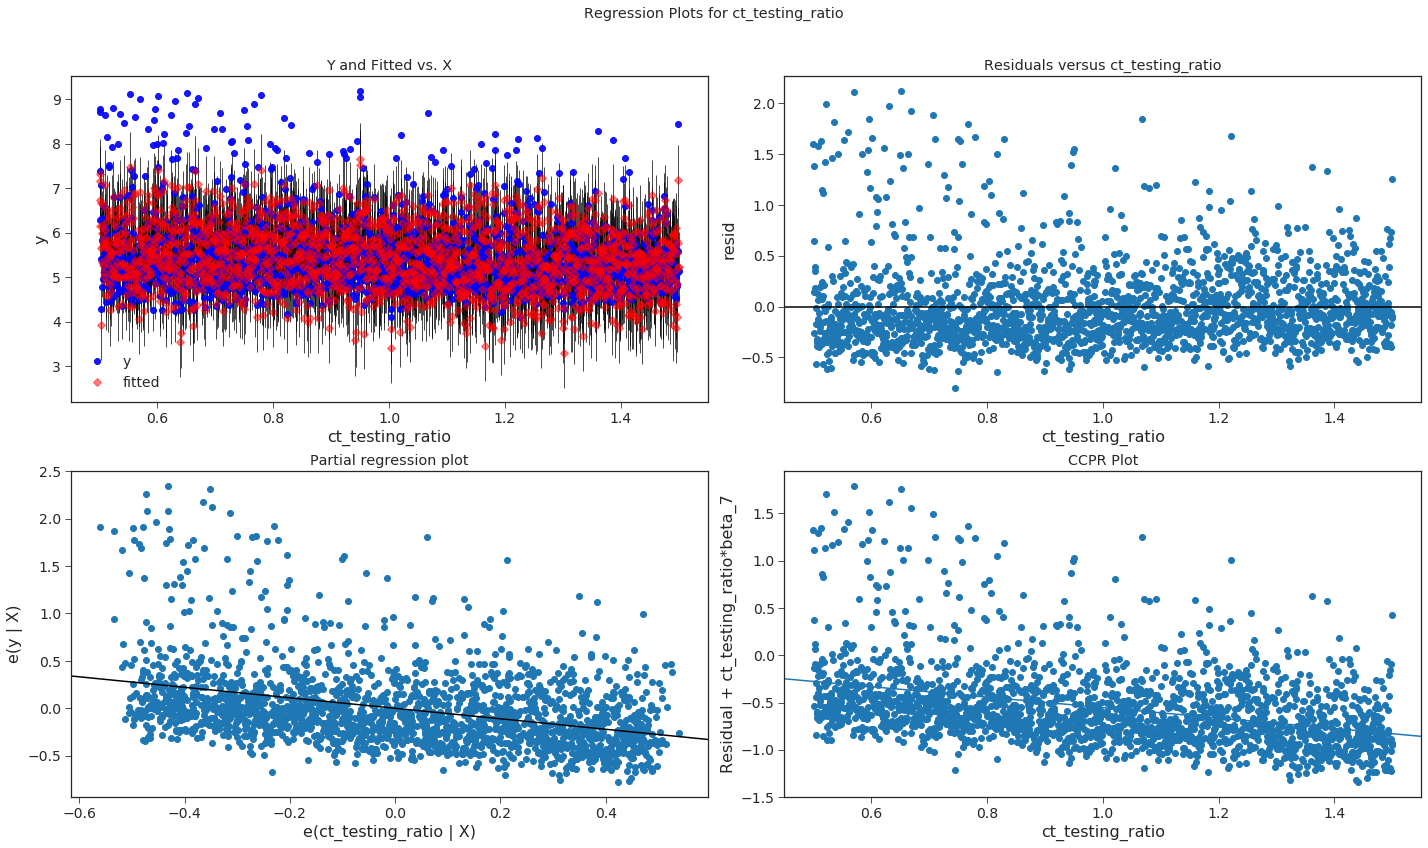

In [45]:
fig = plt.figure(figsize=(20, 12))
fig = sm.graphics.plot_regress_exog(log_results, "ct_testing_ratio", fig=fig)
plt.show()

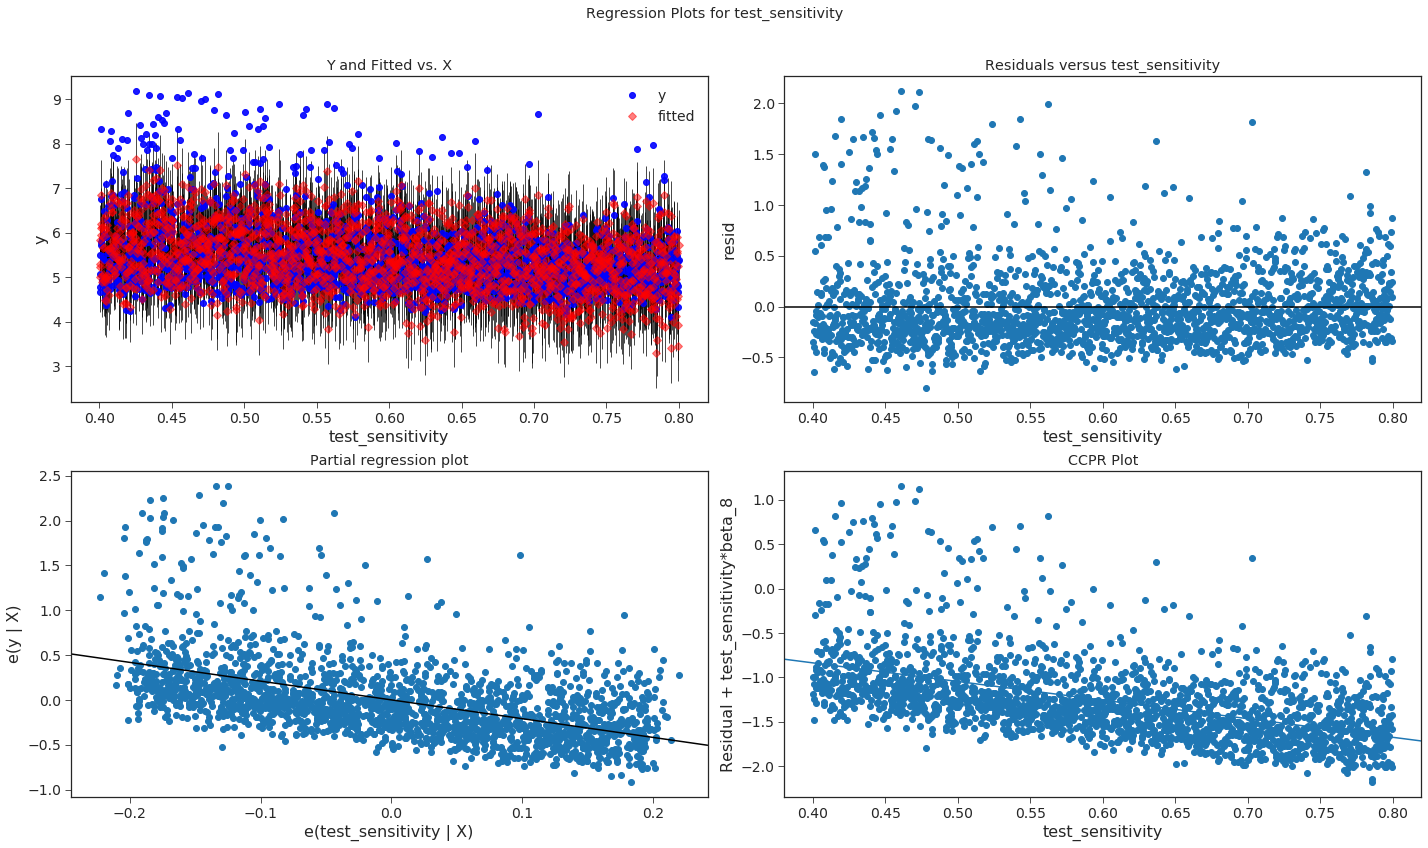

In [46]:
fig = plt.figure(figsize=(20, 12))
fig = sm.graphics.plot_regress_exog(log_results, "test_sensitivity", fig=fig)
plt.show()

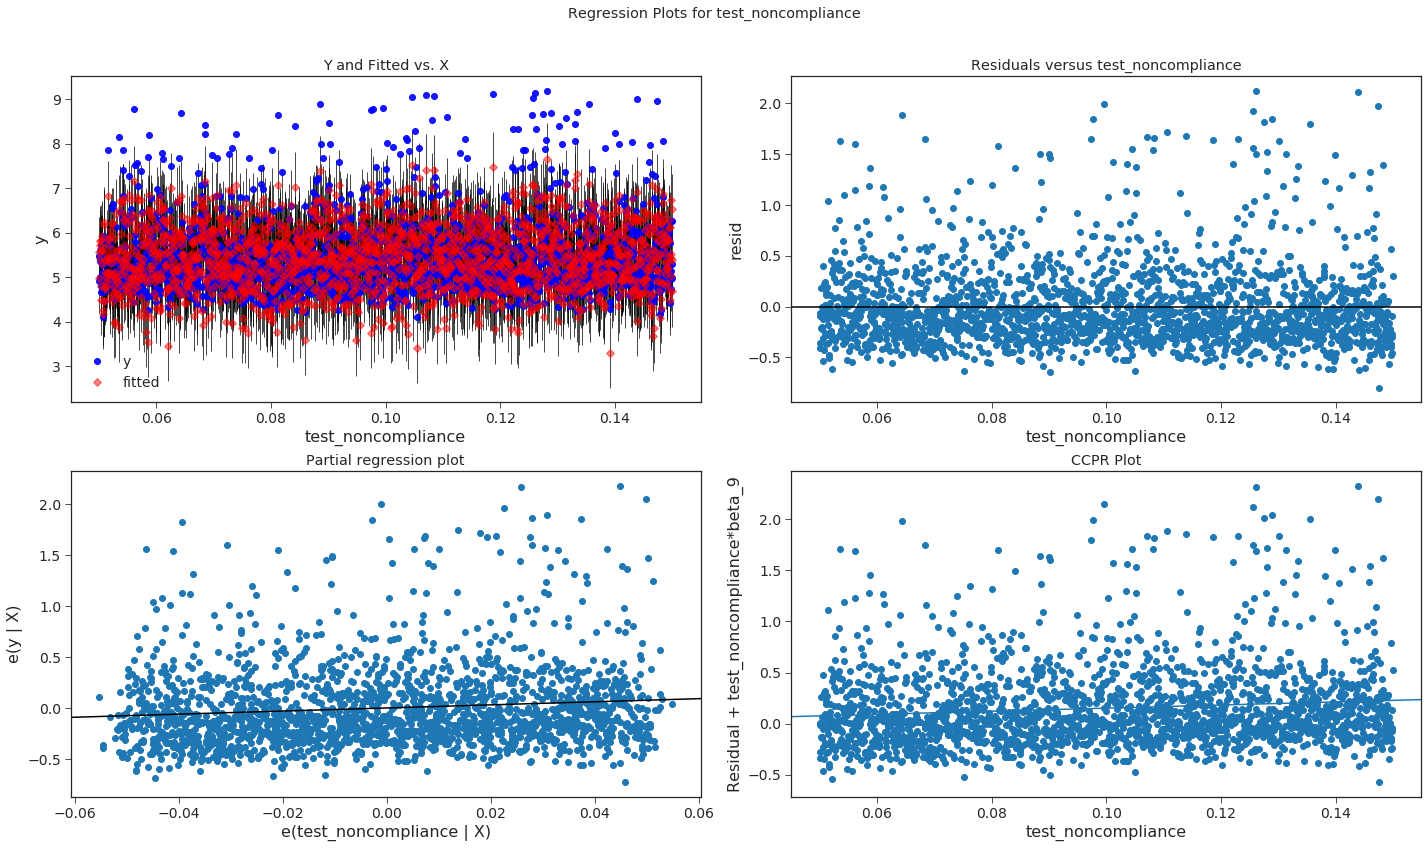

In [47]:
fig = plt.figure(figsize=(20, 12))
fig = sm.graphics.plot_regress_exog(log_results, "test_noncompliance", fig=fig)
plt.show()

In [48]:
def normalize_param(param_name, value):
    lower_bound = PARAM_BOUNDS[param_name][0]
    upper_bound = PARAM_BOUNDS[param_name][1]
    return (value - lower_bound) / (upper_bound - lower_bound)

In [50]:
res_pessimistic = calculate_pessimistic_scenario(res_results)
log_pessimistic = calculate_pessimistic_scenario(log_results)

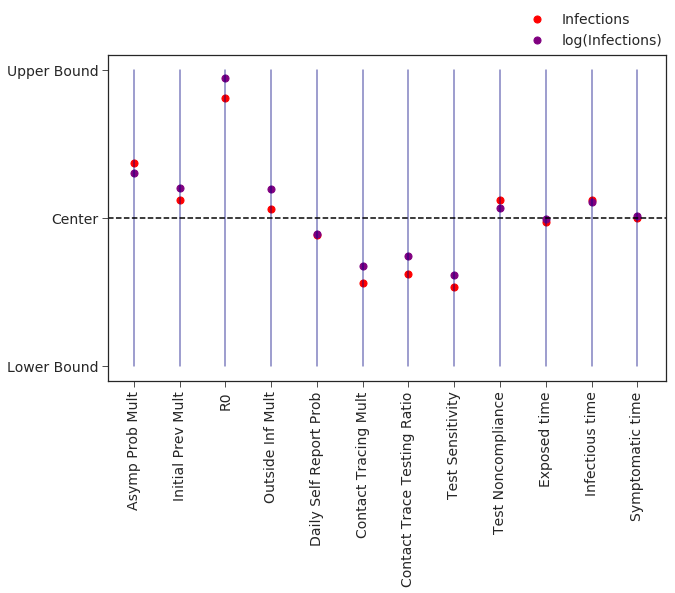

In [54]:
plt.figure(figsize=(10,6))
label = True

for index, param in enumerate(UNCERTAINTY_PARAMS_LIST[:12]):
    plt.plot([index, index], [0,1], color='navy', alpha=0.5)
    if label == True:
        plt.scatter(index, normalize_param(param, res_pessimistic[param]), color='red', label='Infections', s=50)
        plt.scatter(index, normalize_param(param, log_pessimistic[param]), color='purple', label='log(Infections)', s=50)
        label = False
    else:
        plt.scatter(index, normalize_param(param, res_pessimistic[param]), color='red', s=50)
        plt.scatter(index, normalize_param(param, log_pessimistic[param]), color='purple', s=50)

plt.axhline(0.5, color='black', ls='--')

plt.xticks(list(range(len(UNCERTAINTY_PARAMS_LIST[:12]))), ['Asymp Prob Mult', 'Initial Prev Mult', 'R0', 'Outside Inf Mult',
                                          'Daily Self Report Prob', 'Contact Tracing Mult', 'Contact Trace Testing Ratio',
                                          'Test Sensitivity', 'Test Noncompliance', 'Exposed time', 'Infectious time', 'Symptomatic time'])
plt.xticks(rotation = 90)
plt.yticks([0,0.5,1], ['Lower Bound', 'Center', 'Upper Bound'])

# plt.xlabel('Parameter')
# plt.ylabel('Value')

plt.legend(bbox_to_anchor=(0.72,1.17), loc="upper left")
plt.show()